## FDS I final project

Starter notebook to simulate election results for an 11 state country that uses an electoral college system.

### Preliminary stuff

Import the things.

In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

Load the data:

In [2]:
state_pop = np.loadtxt('./final/statePopulations.csv', delimiter=',')
poll_quality = np.loadtxt('./final/poll_quality.csv', delimiter=',')
state_polls = np.loadtxt('./final/state_polls.csv', delimiter=',')

### Explore the data

Data just got dropped in our lap. We need to explore the data a little bit to see what we're dealing with!

Before we ever start doing an "analysis" on data, we always – always – explore the data so we know what we're dealing with, and what further analysis can or should be done.

In [3]:
print(f"""pop vector shape is {state_pop.shape}, 
and poll quality shape is {poll_quality.shape}, 
and state polls shape is {state_polls.shape}""")

pop vector shape is (11,), 
and poll quality shape is (7,), 
and state polls shape is (11, 7)


This all makes sense as we were told that there were 11 states, 7 pollsters, and there should thus be 11x7 poll results (one poll for each state from each pollster).

Let's look at the populations.

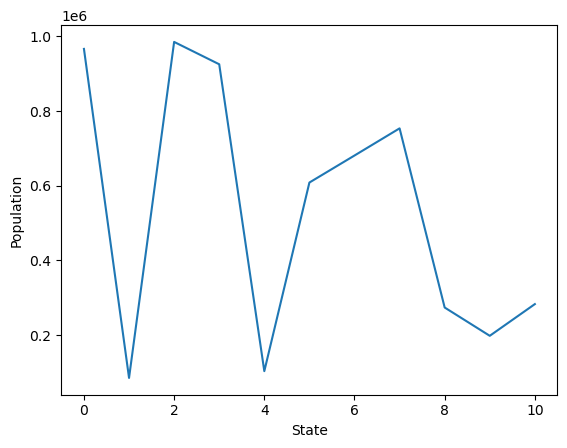

In [4]:
plt.plot(state_pop)
plt.xlabel('State')
plt.ylabel('Population')
plt.show()

So the state populations range from about 1 million to a little over 100,000 people, with the 1st, 3rd, and 4th states being the most populous.

Now let's look at the poll qualities.

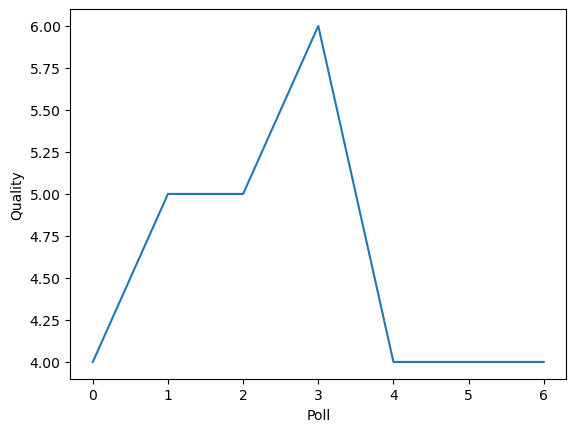

In [5]:
plt.plot(poll_quality)
plt.xlabel('Poll')
plt.ylabel('Quality')
plt.show()

So poll 3 looks like the best (probably done by UT pollsters), and polls 0,4,5, and 6 being of lower quality.

Now let's look at the polling results. But before we do, let's think about what we should see. The polling data from different states could be very different (just as in the U.S. this fictional country could have "red" and "blue" states or whatever). But, if the polls are at all decent, they should be *correlated* across the states. That is, if one poll finds that a state strongly favors Barnes, then another poll shouldn't show that same state strongly favoring Noble. Make sense?

Because the polling data are in an 11 state by 7 poll matrix, we'll look at them as a heatmap – an image in which each pixel value represents the value of a single state/poll combination.

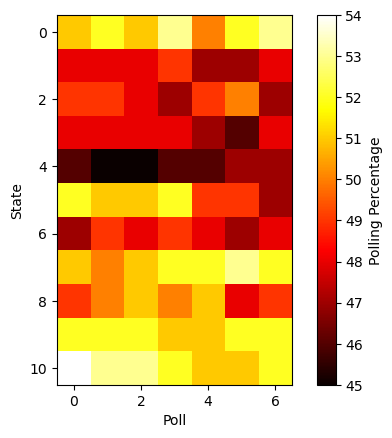

In [6]:
plt.imshow(state_polls, cmap='hot')
plt.colorbar(label="Polling Percentage")
plt.xlabel('Poll')
plt.ylabel('State')
plt.show()


Let's look at this figure and see if it makes sense. Remember, the states can be quite different, but the polls should all reflect the same basic trend across states. And, indeed, we see that all the polls reflect state 4 going for Noble, where as state 10 seems to tilt heavily towards Barnes.

Now that we've wrapped out heads around the data and (hopefully) convinced ourselves that they pass the "sniff test", we can move on to the actual analysis: predicting the outcome of the election.

### Prediction

Before we dive into coding, let's think about what we would do to make a single prediction from the data at hand. In doing that, we'll have figured out what we need to do on each simulated election in our analysis.  

A reasonable approach would be to 

* compute a *weighted average* of the polls for each state, where the weights are the poll qualities
* multiply the resulting average "% for Barnes" estimates by the state populations to get the # of predicted votes for Barnes from each state
* compute the electoral college votes for Barnes for each state
    - determine the states in which Barnes won
    - get the electoral college votes for those states towards Barnes
* sum up the electoral college votes for Barnes across the states
* if the summed electoral college votes for Barnes is more than half of the total number, Barnes wins!

To paint a more complete picture of the election, though (and as per the assignment), we'll also want to store some stuff in addition to whether Barnes wins or not. Like

* the number of electoral college votes for Barnes
* the number of popular (overall) votes for Barnes
* whether or not Barnes would have won the election based on the popular vote (possible to win one but lose the other)

These three items actual don't add much to what we need to do. We've already decided we need to do the first. To compute the other two, we just need to:

* sum the votes from all the states to get the overall popular vote, and store it
* see if popular vote for Barnes was over half the population, and record the result as a win or loss.

*Note*: Whether Barnes won the (electoral college) election or the popular vote can either be computed for each simulation and stored, or computed after all the simulations are done from the vote totals in each simulation. Think about it.

#### Computing the weighted averages of the polls

Let's start with step 1, computing a weighted average for each state. There are some clever ways to do this, but we'll use an easy-to-understand `for()` loop to compute the weighted average for each state.

In [7]:
# compute the average poll value for each state weighted by poll quality
n_states = len(state_pop) # we could set this to 11, but this is more general
weighted_polls = np.zeros(n_states) # initialize the vector for the weighted polls
for i in range(n_states):
    weighted_polls[i] = np.average(state_polls[i,:], weights=poll_quality)
    
    
# compute weighted average
# weight each one by correspinding weight, adding them up, then divide by each weight, numpy does it for us
# mean (x bar) = w1A + w2B + w3C / w1 + w2 + w3

To see if this makes sense, let's plot the original poll values by state, and then plot the weighted averages with a different color & symbol.

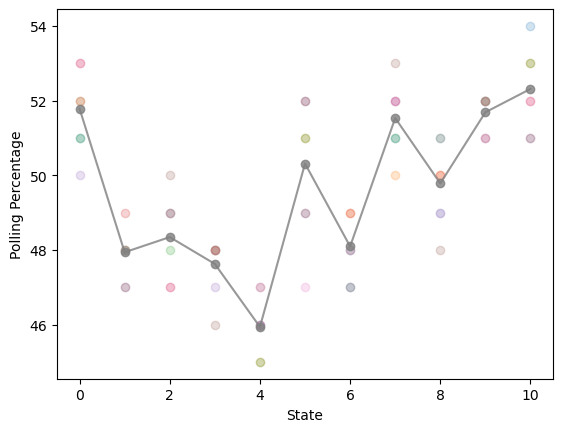

In [8]:
plt.plot(np.arange(11), state_polls, 'o', alpha=0.2);
plt.plot(np.arange(11), weighted_polls, 'o-', alpha=0.8);
plt.xlabel('State')
plt.ylabel('Polling Percentage')
plt.show()

Okay, that looks reasonable. The weighted averages are always somewhere within the poll values, and state 4 has indeed gone for Noble.

#### Computing predicted votes per state

Now let's compute the predicted votes for each state based on our weighted poll average.

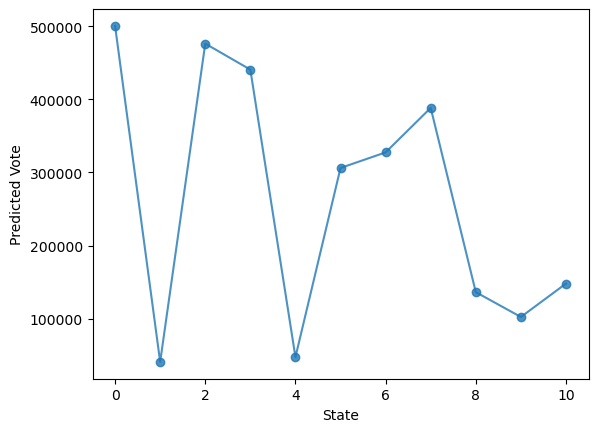

In [9]:
pred_vote_by_state = weighted_polls/100 * state_pop
plt.plot(np.arange(11), pred_vote_by_state, 'o-', alpha=0.8);
plt.xlabel('State')
plt.ylabel('Predicted Vote')
plt.show()

# turn polls into % and multiply by state population

This is a great time for another reality check of our code! Since the polling is all near 50%, the graph of predicted votes we just made should strongly resemble the plot of state populations we made earlier, just scaled down by 0.5 on the y (population) axis.

Scroll back up to the population figure and see if this is true.

#### Compute the electoral college votes for Barnes

Now we need to compute which states Barnes won, and award those electoral college votes to Barnes.

First, let's make a vector indicating how many electoral college votes each state gets:

In [10]:
ppl_per_EC_vote = 1000 # given in the problem
EC_votes_by_state = state_pop/ppl_per_EC_vote 
EC_vote_threshold = sum(EC_votes_by_state)/2

Then we'll compute the states won by Barnes

In [11]:
Barnes_won = pred_vote_by_state > state_pop/2 
Barnes_won

# see if greater than state population
# won, lost, lost, etc. 

array([ True, False, False, False, False,  True, False,  True, False,
        True,  True])

Next, we'll just add up the electoral college votes from all the states that Barnes won.

In [12]:
EC_votes_for_Barnes = np.sum(EC_votes_by_state[Barnes_won])
print(f"Barnes won {EC_votes_for_Barnes} electoral college votes")
if EC_votes_for_Barnes > EC_vote_threshold:
    print("Barnes won!")
else:
    print("Barnes lost...")
    
# fractional is fine, but round if you want

Barnes won 2809.739 electoral college votes
Barnes lost...


#### Compute the popular vote results

This is easy, we just sum the votes across the states.

In [13]:
pred_vote = np.sum(pred_vote_by_state)
pred_vote

2914394.783125

Did Barnes win the election? All we need to determine this is to see if he won more than half of the total votes.

In [14]:
Barnes_won = pred_vote > sum(state_pop)/2
Barnes_won

False

### Doing the simulations

To do the simulations, you need to bundle key parts of the above code (without the plotting and reality checking) into `for()` loop, and store the needed things.

The key is adding realistic variability to the ***polling results*** for each simulation (each pass through the `for()` loop). 

Your new best friend is `rnd.binomial()` – remember that you know the poll sample size (2000 for every poll), and the polling result for each state-by-poll combination, so you can create a new state x poll matrix of polling data for each simulation that reflects the ***binomial*** error that is inherent in the polls.

You also need to add voter turnout variability. You know the population of each state, and you know that, on average, 60% of people turn out to vote, so...

Have at it!

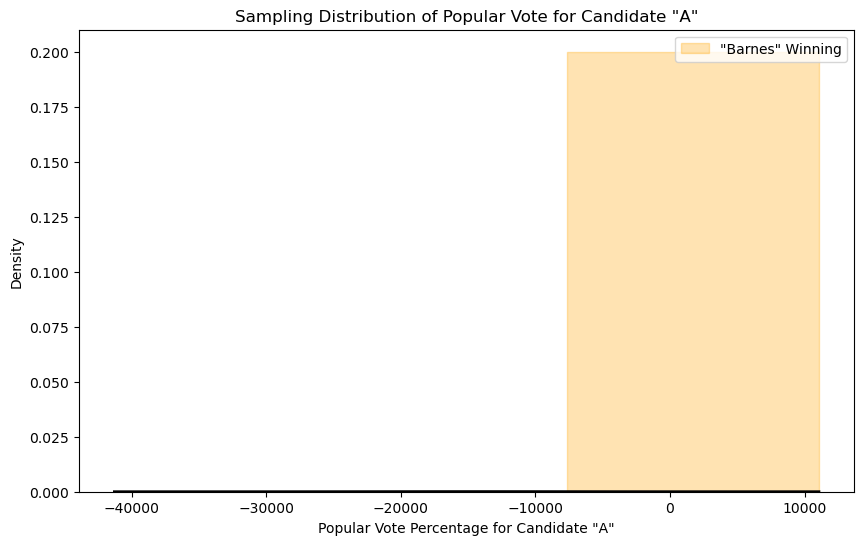

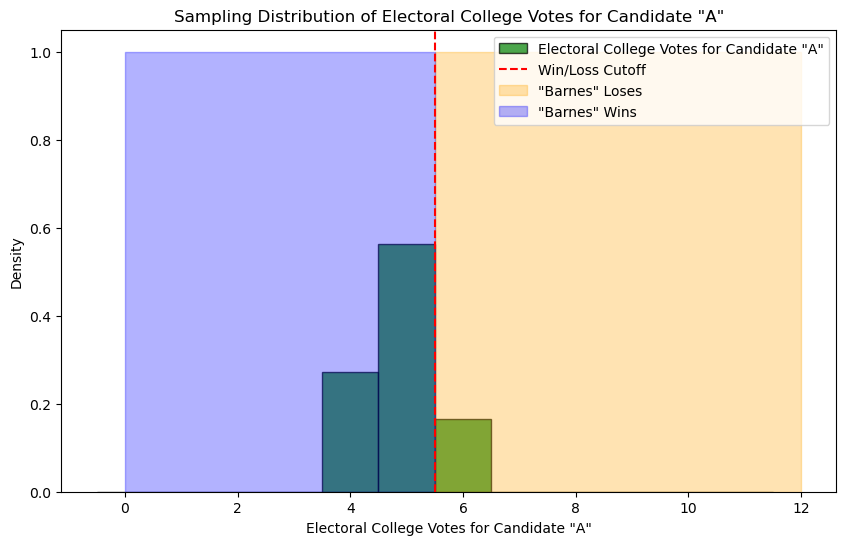

Probability that Candidate 'A' will win the election: 16.45%


In [15]:
# Constants
n_states = len(state_pop)
n_simulations = 10000
voter_turnout_rate = 0.6
votes_per_population = 1 / 1000

# Matrix to store simulation results
simulated_results = np.zeros((n_simulations, n_states))

# Simulation loop
np.random.seed(42)

# Combine polling and voter turnout to get simulated results
for sim in range(n_simulations):
    # Simulate binomial variability in polling results for candidate "Barnes"
    simulated_polls_Barnes = np.random.binomial(n=2000, p=state_polls / 100)

    # Simulate binomial variability in polling results for candidate "Noble"
    simulated_polls_Noble = 2000 - simulated_polls_Barnes

    # Recreate the voter section with variability
    voters = np.zeros((n_states, 7))  # Initialize for each polling entity
    for state in range(n_states):
        # Simulate binomially distributed voter turnout with variability
        voters[state, :] = np.random.binomial(n=state_pop[state], p=voter_turnout_rate, size=7)

    # Combine polling and voter turnout to get simulated results
    simulated_results[sim, :] = np.sum((simulated_polls_Barnes - simulated_polls_Noble) * votes_per_population * voters / 100, axis=1)

# Calculate popular vote percentage for candidate "Barnes"
pop_vote_Barnes = (simulated_results.sum(axis=1) + n_states) / (2 * n_states) * 100

# Plot the popular vote sampling distribution for candidate "A"
plt.figure(figsize=(10, 6))
plt.hist(pop_vote_Barnes, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Popular Vote Percentage for Candidate "A"')
plt.ylabel('Density')

# Fit a normal distribution to the data if std is not zero
mu, std = np.mean(pop_vote_Barnes), np.std(pop_vote_Barnes)
if std != 0:
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    # Shade the area corresponding to "Barnes" winning the popular vote
    shade_start = mu + std
    plt.fill_betweenx(y=[0, 0.2], x1=shade_start, x2=xmax, color='orange', alpha=0.3, label='"Barnes" Winning')

plt.legend()
plt.title('Sampling Distribution of Popular Vote for Candidate "A"')
plt.show()

# Calculate electoral college votes for candidate "A"
elec_college_votes_Barnes = np.sum(simulated_results > 0, axis=1)

# Plot sampling distribution of electoral votes with different colors on each side
plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(elec_college_votes_Barnes, bins=np.arange(0, n_states + 2) - 0.5, density=True, color='green', alpha=0.7, edgecolor='black', label='Electoral College Votes for Candidate "A"')
plt.axvline(x=n_states / 2, color='red', linestyle='--', label='Win/Loss Cutoff')

# Different colors on each side of the win/loss line
plt.fill_betweenx(y=[0, 1], x1=n_states / 2, x2=n_states + 1, color='orange', alpha=0.3, label='"Barnes" Loses')
plt.fill_betweenx(y=[0, 1], x1=0, x2=n_states / 2, color='blue', alpha=0.3, label='"Barnes" Wins')

plt.xlabel('Electoral College Votes for Candidate "A"')
plt.ylabel('Density')
plt.legend()
plt.title('Sampling Distribution of Electoral College Votes for Candidate "A"')
plt.show()

# Calculate overall probability that candidate "A" will win the election
overall_prob_Barnes_win = np.mean(elec_college_votes_Barnes > n_states / 2)
print(f"Probability that Candidate 'A' will win the election: {overall_prob_Barnes_win:.2%}")
